In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.7.1 True


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [3]:
from detectron2.config import get_cfg
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('crowdai_vehicle_detection',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR,"model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
cfg.DATASETS.TEST = ('microcontroller/test', )
predictor = DefaultPredictor(cfg)

In [6]:
import pandas as pd

df = pd.read_csv('labels_crowdai.csv')

df.head()

,xmin,ymin,xmax,ymax,Frame,Label,Preview URL
0,785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1,89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2,268,546,383,650,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
3,455,522,548,615,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
4,548,522,625,605,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...


In [7]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2

# write a function that loads the dataset into detectron2's standard format
def get_data_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['Frame'].map(lambda x: img_dir + x)

    classes = df['Label'].unique().tolist()

    df['class_int'] = df['Label'].map(lambda x: classes.index(x))

    dataset_dicts = []
    for filename in df['filename'].unique().tolist():
        record = {}
        
        #height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = 1200
        record["width"] = 1920

        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

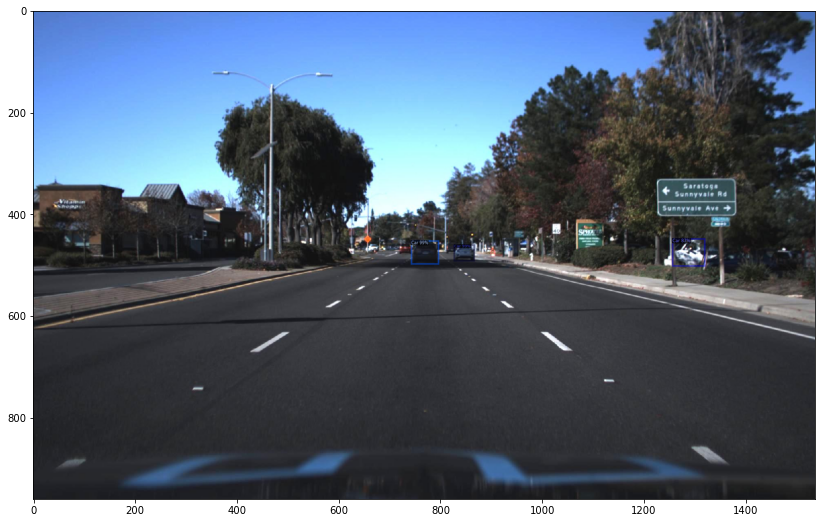

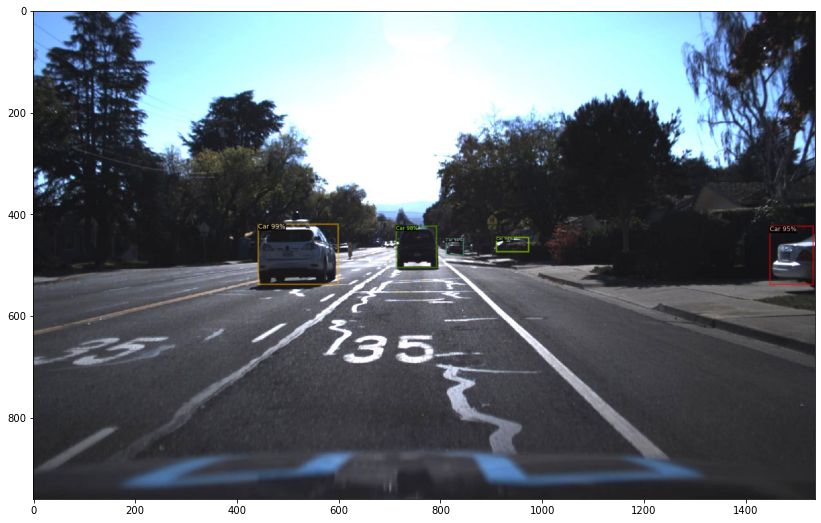

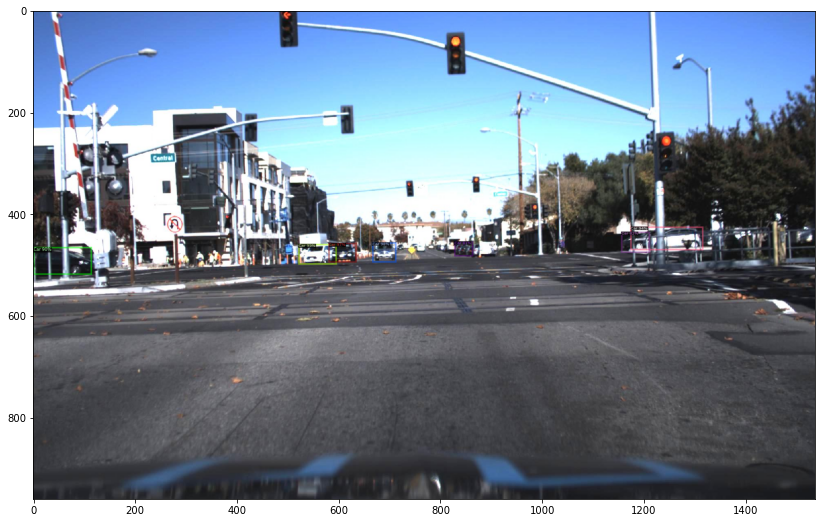

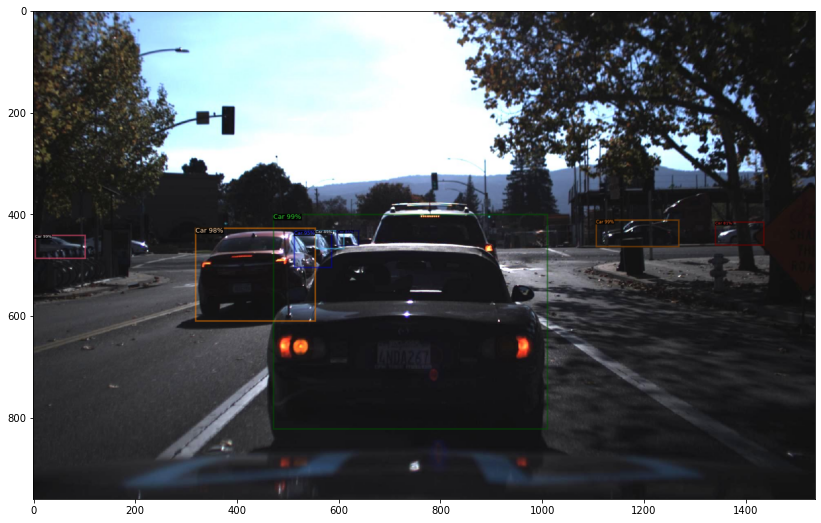

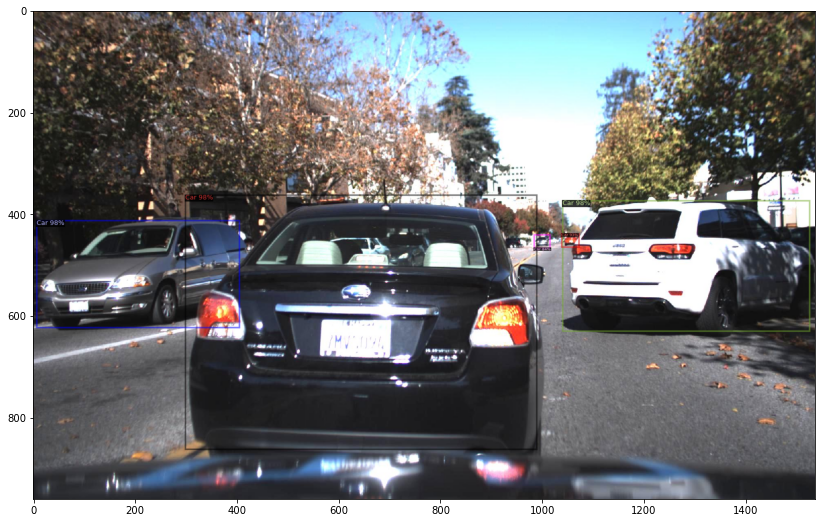

In [8]:
from detectron2.utils.visualizer import ColorMode
import random
from detectron2.data import DatasetCatalog, MetadataCatalog


classes = df['Label'].unique().tolist()
DatasetCatalog.register('crowdai_vehicle_detection', lambda: get_data_dicts('labels_crowdai.csv' , 'object-detection-crowdai/'))
MetadataCatalog.get('crowdai_vehicle_detection').set(thing_classes=classes)
vehicle_detection_metadata = MetadataCatalog.get('crowdai_vehicle_detection')

dataset_dicts = DatasetCatalog.get('crowdai_vehicle_detection')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=vehicle_detection_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()